<a href="https://colab.research.google.com/github/kiddinn/timesketch/blob/colab_updated/notebooks/MUS2019_CTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magnet User Summit CTF 2019


The folks at [Magnet Forensics](https://www.magnetforensics.com/) had a [conference](https://magnetusersummit.com/) recently, and as part of it they put together a digital forensics-themed Capture the Flag competition. I wasn't able to attend, but thankfully they [released the CTF online](https://www.hecfblog.com/2019/04/daily-blog-657-mus2019-dfir-ctf-open-to.html) a few days after the live competition ended. 

It looked like a lot of fun and I wanted to take a crack at it using the open source tools we use/build here at Google. 


## Forensics Preprocessing

I'm going to focus on how to find the answers to the CTF questions after all the processing has been done. I'll quickly summarize the processing steps I did to get to the state when I pick up my walkthrough.

I started off by processing the provided E01 image with a basic log2timeline command; nothing special added:


```
log2timeline.py MUS2019-CTF.plaso MUS-CTF-19-DESKTOP-001.E01
```

Once that finished, I went to [Timesketch](https://github.com/google/timesketch), made a new sketch, and uploaded the MUS2019-CTF.plaso file I just made. The *.plaso* file is a database containing the results of my log2timeline run; Timesketch can read it and provide a nice, collaborative interface for reviewing and exploring that data.

Most of what I'm going to show you is done in Colab by accessing the Timesketch API in Python. You can do most of the steps in the Timesketch web interface directly, but I wanted to demonstrate how you can use Python, Colab, Timesketch, and Plaso together to work a case. 


## Timesketch & Colab Setup


First, if you want to run this notebook and play along, click the 'Connect' button at the top right of the page. The [Timesketch GitHub](https://github.com/google/timesketch) has Colab ([Timesketch and Colab](https://colab.research.google.com/github/google/timesketch/blob/master/notebooks/colab-timesketch-demo.ipynb)) that walks through how to install, connect, and explore a Sketch using Colab. Please check it out if you want a more thorough explanation of the setup; I'm just going to show the commands you need to run to get it working: 

In [2]:
# Install the TimeSketch API client if you don't have it
!pip install timesketch-api-client

# Import some things we'll need
from timesketch_api_client import config
import pandas as pd
pd.options.display.max_colwidth = 60

### Connect to Timesketch

By default, this will connect to the public demo Timesketch server, which [David Cowen](https://twitter.com/HECFBlog) has graciously allowed to host a copy of the Plaso timeline of the MUS2019-CTF. Thanks Dave!

In [3]:
#@title Client Information 
# @markdown In order to connect to Timesketch you need to first get a Timesketch object, which will require you to answer
# @markdown some questions the first time you execute this code. The answers are:
# @markdown + **auth_mode**: timesketch (username/pwd combination)
# @markdown + **host_uri**: https://demo.timesketch.org
# @markdown + **username**: demo
# @markdown + **password**: demo

ts_client = config.get_client()

What is the value for [auth_mode]: timesketch
What is the value for [username]: demo
What is the value for [host_uri]: https://demo.timesketch.org
Password for user demo: ··········


INFO:timesketch_api.crypto_client:File does not exist, creating it.
INFO:timesketch_api.crypto_client:Credentials saved to: /root/.timesketch.token


Now that we've connected to the Timesketch server, we need to select the Sketch that has the CTF timeline. 

First we'll list the available sketches, then print their names:

In [7]:
sketches = ts_client.list_sketches()
ctf = None
for sketch in sketches:
  print('[{0:d}] {1:s}'.format(sketch.id, sketch.name))
  if sketch.name == 'MUS2019 CTF':
    ctf = sketch

[11] aaaa
[10] testcase #123
[9] hello-world
[7] Sigma Test
[6] Szechuan Sauce - Challenge
[2] Look at "Shared With Me" and the sketches there for some data
[1] Greendale
[5] testing
[3] MUS2019 CTF


Then we'll select the MUS2019-CTF sketch (shown as sketch 3 above; you can change the number below to select a different sketch):

In [8]:
print(ctf.name)
print(ctf.description)

MUS2019 CTF
This sketch contains test data from MUS2019 CTF (enter further details here)


Lastly, I'll briefly explain a few paramters of the **explore** function, which we'll use heavily when answering questions.

<sketch_name>.explore() is how we send queries to Timesketch and get results back. **query_string**, **return_fields**, and **as_pandas** are the main parameters I'll be using:
 - query_string: This is the same as the query you'd enter if you were using the Timesketch web interface.
 - return_fields: Here we specify what fields we want back from Timesketch. This is where we can get really specific using Colab and only get the things we're interested in (which varies depending on what data types we're expecting back).
 - as_pandas: This just a boolen value which tells Timesketch to return a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), rather than a dictionary. We'll have this set to True in all our queries, since DataFrames are awesome!

Okay, enough setup. Let's get to answering questions!

# Questions


![Basic - Desktop Questions](https://dfir.blog/content/images/2019/04/MUS2019-CTF-Basic-Desktop.png)

I grouped the questions from the 'Basic - Desktop' section into three categories: NTFS, TeamViewer, and Registry.

## NTFS Questions
This first set of questions relate to aspects of NTFS: MFT entries, sequence numbers, USN entries, and VSNs.

As a little refresher, the 64-bit **file reference address** (or number) is made up of the **MFT entry** (48 bits) and **sequence** (16 bits) numbers. We often see this represented as something like 1234-2, with 1234 being the MFT entry number and 2 being the sequence number. Plaso calls the MFT entry number the **inode**, since that's the more generic term that applies across file systems.

### Q: What is the name of the file associated with MFT entry number 102698?

Since Plaso parses out the MFT entry (or as it calls it, inode) into its own field, let's do a query for all records with that value:

In [15]:
ts_results = ctf.explore(
    'inode:102698', 
    return_fields='datetime,timestamp_desc,data_type,inode,filename', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','inode','filename']]

,datetime,timestamp_desc,data_type,inode,filename
0,2019-02-25 20:39:59.821777+00:00,Creation Time,fs:stat,102698,\Users\Administrator\Downloads\TeamViewer_Setup.exe
1,2019-02-25 20:40:29.915533+00:00,Content Modification Time,fs:stat,102698,\Users\Administrator\Downloads\TeamViewer_Setup.exe
2,2019-02-25 20:40:45.238474+00:00,Metadata Modification Time,fs:stat,102698,\Users\Administrator\Downloads\TeamViewer_Setup.exe
3,2019-02-25 20:41:35.639840+00:00,Last Access Time,fs:stat,102698,\Users\Administrator\Downloads\TeamViewer_Setup.exe


Multiple results, as is expected since Plaso creates multiple records for different types of timestamps, but they all point to the same filename: **/Users/Administrator/Downloads/TeamViewer_Setup.exe**

In [16]:
ts_results.filename.unique()

array(['\\Users\\Administrator\\Downloads\\TeamViewer_Setup.exe'],
      dtype=object)

### Q: What is the file name that represented MFT entry 60725 with a sequence number of 10?

The quick way to answer this is to just search for the MFT entry number (60725) and look for references to sequence number 10 in the message field:

In [17]:
ts_results = ctf.explore(
    '60725', 
    return_fields='datetime,timestamp_desc,data_type,filename,message', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','filename','message']]

,datetime,timestamp_desc,data_type,filename,message
0,2019-02-26 23:59:41.039993+00:00,Content Modification Time,windows:evtx:record,NaN,[2006 / 0x07d6] Source Name: Microsoft-Windows-Install-A...
1,2019-02-26 23:59:41.039993+00:00,Creation Time,windows:evtx:record,NaN,[2006 / 0x07d6] Source Name: Microsoft-Windows-Install-A...
2,2019-03-13 19:23:17.126646+00:00,Creation Time,fs:stat,\ProgramData\Microsoft\Diagnosis\DownloadedSettings\utc....,NTFS:\ProgramData\Microsoft\Diagnosis\DownloadedSettings...
3,2019-03-13 19:23:17.583458+00:00,Content Modification Time,fs:stat,\ProgramData\Microsoft\Diagnosis\DownloadedSettings\utc....,NTFS:\ProgramData\Microsoft\Diagnosis\DownloadedSettings...
4,2019-03-13 19:23:17.583458+00:00,Last Access Time,fs:stat,\ProgramData\Microsoft\Diagnosis\DownloadedSettings\utc....,NTFS:\ProgramData\Microsoft\Diagnosis\DownloadedSettings...
5,2019-03-13 19:23:17.583458+00:00,Metadata Modification Time,fs:stat,\ProgramData\Microsoft\Diagnosis\DownloadedSettings\utc....,NTFS:\ProgramData\Microsoft\Diagnosis\DownloadedSettings...


That's a bunch of rows, so let's filter it down by searching for messages that contain '60725-10':

In [19]:
ts_results[ts_results.message.str.contains('60725-10')]

,data_type,datetime,label,message,timestamp_desc,filename


That filename is really long and cut off; let's just select that field, then deduplicate using set():

In [12]:
set(ts_results[ts_results.message.str.contains('60725-10')].filename)

set()

Another way to solve this is to query for the file reference number directly. That's not as easy as it sounds, since Plaso stores it in the hex form ([I'm working on fixing that](https://github.com/log2timeline/plaso/issues/2453)). We can work with that though! 

Let's do the same query as above, but add the file_reference field:

In [13]:
ts_results = ctf.explore(
    '60725', 
    return_fields='datetime,timestamp_desc,data_type,file_reference,filename,message', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','file_reference','filename','message']]

KeyError: ignored

The *file_reference* value is not the format we want, since it's hard to tell what the sequence number is. We can convert it to a more useful form though: 

In [ ]:
# Drop any rows with NaN, since they aren't what we're looking for and will 
# break the below function.
ts_results = ts_results.dropna()
pd.options.display.max_colwidth = 110

# Replace the file_reference hex value with the human-readable MFT-Seq version. 
# This is basically what Plaso does to display the result in the 'message' 
# string we searched for. 
ts_results['file_reference'] = ts_results['file_reference'].map(
    lambda x: '{0:d}-{1:d}'.format(int(x) & 0xffffffffffff, int(x) >> 48))
ts_results[['datetime','timestamp_desc','data_type','file_reference','filename']]

There. Now we have the file_reference number in an easier-to-read format, and the history of all filenames that MFT entry 60725 has had! It's easy to look for the entry with a sequence number of 10 and get our answer.

### Q: Which file name represents the USN record where the USN number is 546416480?

Like other questions, the quick, generic way to answer is to just search for the unique detail; in this case, search in Timesketch for '546416480'. I'll show the more targeted way below, but it's pretty simple:

In [22]:
ts_results = ctf.explore(
    'update_sequence_number:546416480', 
    return_fields='datetime,timestamp_desc,data_type,update_sequence_number,filename', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','update_sequence_number','filename']]

KeyError: ignored

### Q: What is the MFT sequence number associated with the file "\Users\Administrator\Desktop\FTK_Imager_Lite_3.1.1\FTK Imager.exe"?

We'll handle this question like other ones involving the file reference address, except in this case we first need to find the MFT entry number (or inode) from the file name. Searching for the whole file path in Timesketch is problematic (slashes among other things), so let's search for the file name and then verify the path is right:

In [25]:
ts_results = ctf.explore(
    'FTK Imager.exe', 
    return_fields='datetime,timestamp_desc,data_type,inode,message,filename', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','inode','message']]

,datetime,timestamp_desc,data_type,inode,message
0,2012-08-23 20:54:54+00:00,Creation Time,pe:compilation:compilation_time,NaN,PE Type: Executable (EXE) Import hash: 5d1d1d8cdc2296dfc...
1,2016-04-13 22:33:42+00:00,Content Modification Time,fs:stat,99916.0,NTFS:\Users\Administrator\Desktop\FTK_Imager_Lite_3.1.1\...
2,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,NaN,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE...
3,2019-03-20 13:42:25.006134+00:00,Metadata Modification Time,fs:stat,99916.0,NTFS:\Users\Administrator\Desktop\FTK_Imager_Lite_3.1.1\...
4,2019-03-20 21:26:48.956899+00:00,Creation Time,fs:stat,99916.0,NTFS:\Users\Administrator\Desktop\FTK_Imager_Lite_3.1.1\...
5,2019-03-20 21:26:49.127618+00:00,Last Access Time,fs:stat,99916.0,NTFS:\Users\Administrator\Desktop\FTK_Imager_Lite_3.1.1\...
6,2019-03-20 21:27:01.697998+00:00,Last Time Executed,windows:prefetch:execution,NaN,Prefetch [FTK IMAGER.EXE] was executed - run count 1 pat...
7,2019-03-20 21:27:11.833271+00:00,Content Modification Time,fs:stat,977.0,NTFS:\Windows\Prefetch\FTK IMAGER.EXE-C7E9245B.pf Type: ...
8,2019-03-20 21:27:11.833271+00:00,Creation Time,fs:stat,977.0,NTFS:\Windows\Prefetch\FTK IMAGER.EXE-C7E9245B.pf Type: ...
9,2019-03-20 21:27:11.833271+00:00,Last Access Time,fs:stat,977.0,NTFS:\Windows\Prefetch\FTK IMAGER.EXE-C7E9245B.pf Type: ...


In the second row of the results, we can find the correct path we're looking for in the message and see that the corresponding inode is 99916. We could do another search, similar to how we answered other questions... or we could just look down a few rows for a USN entry that shows: "FTK Imager.exe File reference: 99916-**4**".  There's the answer!

In [30]:
ts_results[
    ~ts_results.filename.isna() & (
        ts_results.filename.str.contains(r'Users\\Administrator\\Desktop\\FTK_Imager_Lite_3.1.1\\FTK Imager.exe'))][['filename', 'inode']].drop_duplicates()

,filename,inode
1,\Users\Administrator\Desktop\FTK_Imager_Lite_3.1.1\FTK I...,99916.0


### Q: What is the Volume Serial Number of the Desktop's OS volume?

I know the VSN can be found in multiple places, but the first one I thought of was as part of a Prefetch file, so let's do it that way. 

I'll search for all 'volume creation' Prefetch records, since I don't really care about which particular one, beyond that it's from the OS drive. 

In [31]:
ts_results = ctf.explore(
    'data_type:"windows:volume:creation"', 
    return_fields='datetime,timestamp_desc,data_type,device_path,hostname,serial_number,message', 
    as_pandas=True)
pd.options.display.max_colwidth = 70
ts_results[['datetime','timestamp_desc','data_type','device_path','hostname','serial_number','message']]

,datetime,timestamp_desc,data_type,device_path,hostname,serial_number,message
0,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,\VOLUME{01d4264bee777579-ccee841b},DESKTOP-0QT8017,3438183451,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE841B Origi...
1,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,\VOLUME{01d4264bee777579-ccee841b},DESKTOP-0QT8017,3438183451,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE841B Origi...
2,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,\VOLUME{01d4264bee777579-ccee841b},DESKTOP-0QT8017,3438183451,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE841B Origi...
3,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,\VOLUME{01d4264bee777579-ccee841b},DESKTOP-0QT8017,3438183451,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE841B Origi...
4,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,\VOLUME{01d4264bee777579-ccee841b},DESKTOP-0QT8017,3438183451,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE841B Origi...
...,...,...,...,...,...,...,...
207,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,\VOLUME{01d4264bee777579-ccee841b},DESKTOP-0QT8017,3438183451,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE841B Origi...
208,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,\VOLUME{01d4264bee777579-ccee841b},DESKTOP-0QT8017,3438183451,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE841B Origi...
209,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,\VOLUME{01d4264bee777579-ccee841b},DESKTOP-0QT8017,3438183451,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE841B Origi...
210,2018-07-28 08:21:06.579596+00:00,Creation Time,windows:volume:creation,\VOLUME{01d4264bee777579-ccee841b},DESKTOP-0QT8017,3438183451,\VOLUME{01d4264bee777579-ccee841b} Serial number: 0xCCEE841B Origi...


You can see the VSN in a readable format at the end of the device_path or in the message string. I'm only seeing one value here, so we don't need to determine which drive was the OS one. If we did, I'd look for some system processes that need to run from the OS drive to get the right VSN. 

That's good enough for the question, but let's also convert the serial_number field from an integar to the hex format the answer wants, just to be sure:

In [34]:
for serial_nr in ts_results.serial_number.unique():
  print('{0:08X}'.format(serial_nr))

CCEE841B


## TeamViewer Questions
The next group of questions involved [TeamViewer](https://www.teamviewer.com/en-us/), a common remote desktop program.

### Q: Which user installed Team Viewer?

We can start searching very broadly, then focus in on anything that stands out. Let's just search everything we have for "TeamViewer":

In [40]:
ts_results = ctf.explore(
    'TeamViewer', 
    return_fields='datetime,timestamp_desc,timestamp,data_type,message', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','message']]

,datetime,timestamp_desc,data_type,message
0,1970-01-01 00:00:00+00:00,Last Time Executed,windows:registry:userassist,[HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\Explo...
1,2007-12-13 09:22:09+00:00,Creation Time,pe:compilation:compilation_time,PE Type: Driver (SYS) Import hash: fcbe966aa9c0053fe3d2d7f07dbdd41d
2,2016-04-03 20:18:56+00:00,Creation Time,pe:compilation:compilation_time,PE Type: Executable (EXE) Import hash: 4ea4df5d94204fc550be1874e1b...
3,2016-04-03 20:19:02+00:00,Creation Time,pe:compilation:compilation_time,PE Type: Executable (EXE) Import hash: e2a592076b17ef8bfb48b7e0396...
4,2017-05-12 08:54:01+00:00,Creation Time,pe:compilation:compilation_time,PE Type: Driver (SYS) Import hash: bd2fee8a544a1c6656edb847a80a08c5
...,...,...,...,...
674,2019-03-20 21:15:27.923684+00:00,Previous Last Time Executed,windows:prefetch:execution,Prefetch [DLLHOST.EXE] was executed - run count 5 path hints: \WIN...
675,2019-03-20 21:15:35.804750+00:00,Last Time Executed,windows:prefetch:execution,Prefetch [DLLHOST.EXE] was executed - run count 5 path hints: \WIN...
676,2019-03-20 21:15:59.479903+00:00,Last Time Executed,windows:prefetch:execution,Prefetch [TASKHOSTW.EXE] was executed - run count 937 path hints: ...
677,2019-03-20 21:16:00.296180+00:00,Last Time Executed,windows:prefetch:execution,Prefetch [DLLHOST.EXE] was executed - run count 25 path hints: \WI...


That returned a lot of results (600+). We could page through them all, but why not see if there are any interesting clusters first? That sounds like a job for a visualization!

You can do this multiple ways; I'll do it in Python in a second, but the explanation is a bit complicated. The easier way is to do the search in TImesketch, then go to Charts > Histogram:

![alt text](https://dfir.blog/content/images/2019/04/timesketch-histogram.png)

And here's how you'd do something similar in Python:

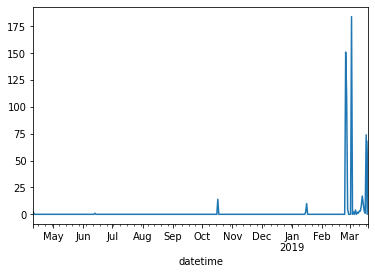

In [41]:
ts_results = ts_results.set_index('datetime')
ts_results['2018':].message.resample('D').count().plot()

Or to use grouping/aggregation in pandas

In [46]:
ts_results.reset_index(inplace=True)
ts_results['day'] = ts_results.datetime.dt.strftime('%Y%m%d')
group = ts_results[['day', 'timestamp']].groupby('day', as_index=False)

group_df = group.count().rename(columns={'timestamp': 'count'})


In [50]:
group_df.sort_values('count', ascending=False)[:10]

,day,count
12,20190303,184
9,20190225,151
10,20190226,109
24,20190318,74
25,20190320,68
20,20190314,17
6,20181017,14
21,20190315,10
8,20190116,10
19,20190313,8


Okay, so from the graphs it looks like we have a good cluster at the end of February; let's look closer. I'll slice the results to only show after 2019-02-20:

In [52]:
query_filter = {
    'time_start': '2019-02-25',
    'time_end': '2019-03-04'
}
ts_results = ctf.explore(
    'TeamViewer', 
    return_fields='*', query_filter=query_filter, as_pandas=True)
#ts_results = ts_results.set_index('datetime')
#ts_results['2019-02-20':][['timestamp_desc','data_type','filename','message']]

In [53]:
ts_results.data_type.value_counts()

fs:stat                                       264
pe:compilation:compilation_time                46
windows:evtx:record                            36
windows:shell_item:file_entry                  31
windows:registry:key_value                     28
windows:prefetch:execution                     12
windows:lnk:link                               12
chrome:cache:entry                              7
windows:registry:appcompatcache                 7
chrome:history:page_visited                     3
windows:distributed_link_tracking:creation      2
windows:registry:service                        1
Name: data_type, dtype: int64

In [54]:
ts_results.search_string.value_counts()

teamviewer    1
Name: search_string, dtype: int64

In [58]:
ts_results[ts_results.data_type.str.contains('chrome')][['datetime', 'url', 'domain', 'search_string', 'message', 'title']]

,datetime,url,domain,search_string,message,title
2,2019-02-25 20:39:40.704631+00:00,NaN,NaN,NaN,Original URL: https://www.google.com/search?q=teamviewer&oq=teamv&...,NaN
3,2019-02-25 20:39:40.892631+00:00,https://www.google.com/search?q=teamviewer&oq=teamv&aqs=chrome.1.6...,www.google.com,teamviewer,https://www.google.com/search?q=teamviewer&oq=teamv&aqs=chrome.1.6...,teamviewer - Google Search
4,2019-02-25 20:39:45.709631+00:00,https://www.teamviewer.com/en-us/,www.teamviewer.com,NaN,https://www.teamviewer.com/en-us/ (Home - TeamViewer) [count: 0] T...,Home - TeamViewer
5,2019-02-25 20:39:46.099631+00:00,NaN,NaN,NaN,Original URL: https://static.teamviewer.com/resources/2018/10/logo...,NaN
6,2019-02-25 20:39:54.042631+00:00,NaN,NaN,NaN,Original URL: https://www.teamviewer.com/en-us/teamviewer-automati...,NaN
7,2019-02-25 20:39:54.789631+00:00,https://www.teamviewer.com/en-us/teamviewer-automatic-download/,www.teamviewer.com,NaN,https://www.teamviewer.com/en-us/teamviewer-automatic-download/ (T...,TeamViewer Automatic Download - TeamViewer
8,2019-02-25 20:39:59.189631+00:00,NaN,NaN,NaN,Original URL: https://tracking.g2crowd.com/attribution_tracking/co...,NaN
9,2019-02-25 20:39:59.984631+00:00,NaN,NaN,NaN,Original URL: https://bat.bing.com/action/0?ti=26037780&Ver=2&mid=...,NaN
10,2019-02-25 20:39:59.993631+00:00,NaN,NaN,NaN,Original URL: https://bat.bing.com/action/0?ti=5712416&Ver=2&mid=4...,NaN
11,2019-02-25 20:40:09.673631+00:00,NaN,NaN,NaN,Original URL: https://static.teamviewer.com/resources/2018/10/team...,NaN


In [60]:
ts_results[ts_results.data_type == 'fs:stat'][['datetime', 'display_name', 'timestamp_desc']]

,datetime,display_name,timestamp_desc
12,2019-02-25 20:40:47.017096+00:00,NTFS:\Users\Administrator\AppData\Local\Temp\TeamViewer,Creation Time
13,2019-02-25 20:40:47.068462+00:00,NTFS:\Program Files (x86)\TeamViewer\tvinfo.ini,Content Modification Time
14,2019-02-25 20:40:47.068462+00:00,NTFS:\Program Files (x86)\TeamViewer\tvinfo.ini,Metadata Modification Time
15,2019-02-25 20:40:47.068462+00:00,NTFS:\Users\Administrator\AppData\Local\Temp\TeamViewer\TeamViewer...,Metadata Modification Time
16,2019-02-25 20:40:47.068462+00:00,NTFS:\Users\Administrator\AppData\Local\Temp\TeamViewer\tvinfo.ini,Content Modification Time
...,...,...,...
440,2019-03-03 21:50:47.742384+00:00,NTFS:\Program Files (x86)\TeamViewer\x64,Metadata Modification Time
441,2019-03-03 21:50:47.742384+00:00,NTFS:\Program Files (x86)\TeamViewer\x64\TeamViewerVPN.sy_,Metadata Modification Time
442,2019-03-03 21:50:48.872722+00:00,NTFS:\Users\Administrator\AppData\Local\Temp\TeamViewer\TV14Instal...,Content Modification Time
443,2019-03-03 21:50:48.872722+00:00,NTFS:\Users\Administrator\AppData\Local\Temp\TeamViewer\TV14Instal...,Last Access Time


So from this, in a short interval starting 2019-02-25T20:39, we can see:
*  a Google search for "teamviewer"
*  a visit in Chrome to teamviewer.com,
*  then teamviewer.com/en-us/teamviewer-automatic-download/,
*  and lastly a bunch of TeamViewer related files being created.

The web browser and files created were done under the Administrator account (per the path filename), so that's our answer.

### Q: How Many Times
At least how many times did the teamviewer_desktop.exe run?

Prefetch is a great artifact for "how many times did something run"-type questions, so let's look for Prefetch execution entries for the program in question:

In [61]:
ts_results = ctf.explore(
    'data_type:"windows:prefetch:execution" AND teamviewer_desktop.exe', 
    return_fields='datetime,timestamp_desc,data_type,executable,run_count,message', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','executable','run_count','message']]

,datetime,timestamp_desc,data_type,executable,run_count,message
0,2019-03-18 17:59:20.791307+00:00,Previous Last Time Executed,windows:prefetch:execution,TEAMVIEWER_DESKTOP.EXE,3,Prefetch [TEAMVIEWER_DESKTOP.EXE] was executed - run count 3 path ...
1,2019-03-18 18:34:19.242037+00:00,Previous Last Time Executed,windows:prefetch:execution,TEAMVIEWER_DESKTOP.EXE,3,Prefetch [TEAMVIEWER_DESKTOP.EXE] was executed - run count 3 path ...
2,2019-03-18 18:36:49.217664+00:00,Last Time Executed,windows:prefetch:execution,TEAMVIEWER_DESKTOP.EXE,3,Prefetch [TEAMVIEWER_DESKTOP.EXE] was executed - run count 3 path ...


### Q: Execute Where
After looking at the TEAMVIEWER_DESKTOP.EXE prefetch file, which path was the executable in at the time of execution?



We did all the work for this question with the previous query (the answer is in the message string), but we can explicitly query for the path:

In [65]:
ts_results = ctf.explore(
    'data_type:"windows:prefetch:execution" AND teamviewer_desktop.exe', 
    return_fields='*',  as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','executable','run_count', 'path_hints']]

,datetime,timestamp_desc,data_type,executable,run_count,path_hints
0,2019-03-18 17:59:20.791307+00:00,Previous Last Time Executed,windows:prefetch:execution,TEAMVIEWER_DESKTOP.EXE,3,[\PROGRAM FILES (X86)\TEAMVIEWER\TEAMVIEWER_DESKTOP.EXE]
1,2019-03-18 18:34:19.242037+00:00,Previous Last Time Executed,windows:prefetch:execution,TEAMVIEWER_DESKTOP.EXE,3,[\PROGRAM FILES (X86)\TEAMVIEWER\TEAMVIEWER_DESKTOP.EXE]
2,2019-03-18 18:36:49.217664+00:00,Last Time Executed,windows:prefetch:execution,TEAMVIEWER_DESKTOP.EXE,3,[\PROGRAM FILES (X86)\TEAMVIEWER\TEAMVIEWER_DESKTOP.EXE]


## Registry Questions
This last set of questions can be answered using the Windows Registry (and one from event logs).

Lots of registry questions depend on the Current Control Set, so let's verify what it is:

In [66]:
# Escaping fun: We need to esacpe the slashes in the key_path once for Timesketch and once for Python, so we'll have triple slashes (\\\)
ts_results = ctf.explore(
    'data_type:"windows:registry:key_value" AND key_path:"HKEY_LOCAL_MACHINE\\\System\\\Select"', 
    return_fields='datetime,timestamp_desc,data_type,message', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','message']]

,datetime,timestamp_desc,data_type,message
0,2018-04-11 23:38:44.315360+00:00,Content Modification Time,windows:registry:key_value,[HKEY_LOCAL_MACHINE\System\Select] Current: [REG_DWORD_LE] 1 Defau...


From the message, the Current control set is 1.

### Q: What was the timezone offset at the time of imaging? and What is the timezone of the Desktop

I'm combining these, since the answer is in the same query:

In [74]:
ts_results = ctf.explore(
    'data_type:"windows:registry:timezone"', 
    return_fields='datetime,timestamp_desc,data_type,message', 
    as_pandas=True)

ts_results[['datetime','timestamp_desc','data_type','message']]

,datetime,timestamp_desc,data_type,message
0,2019-03-10 10:00:00.000413+00:00,Content Modification Time,windows:registry:timezone,[HKEY_LOCAL_MACHINE\System\ControlSet001\Control\TimeZoneInformati...


The message is really long; let's pull it out:

In [83]:
message = list(ts_results.message.unique())[0]
buffer = []
first = True
key = ''
for word in message.split():
  if first:
    print(word)
    first = False
    continue

  if not word.endswith(':'):
    buffer.append(word)
    continue
  
  if key:
    words = ' '.join(buffer)
    buffer = []
    print(f'{" "*4}{key} = {words}')

  key = word[:-1]

words = ' '.join(buffer)
buffer = []
print(f'{" "*4}{key} = {words}')


[HKEY_LOCAL_MACHINE\System\ControlSet001\Control\TimeZoneInformation]
    ActiveTimeBias = 420
    Bias = 480
    DaylightBias = -60
    DaylightName = @tzres.dll,-211
    DynamicDaylightTimeDisabled = 0
    StandardBias = 0
    StandardName = @tzres.dll,-212
    TimeZoneKeyName = Pacific Standard Time


The name of the Timezone is in the message string, as is the ActiveTimeBias, which we can use to get the UTC offset:

In [ ]:
# The ActiveTimeBias is in minutes, so divide by -60 (I don't know why it's stored negative): 
420 / -60

### Q: When was the Windows OS installed?

Plaso actually parses this out as it's own data_type, so querying for it is easy:

In [84]:
ts_results = ctf.explore(
    'data_type:"windows:registry:installation"', 
    return_fields='datetime,timestamp_desc,data_type,message', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','message']]

,datetime,timestamp_desc,data_type,message
0,1970-01-01 00:00:00+00:00,Installation Time,windows:registry:installation,Windows 10 Enterprise 6.3 17134 Owner: User Origin: HKEY_LOCAL_MAC...
1,2018-07-28 07:27:53+00:00,Installation Time,windows:registry:installation,Windows 10 Enterprise 6.3 17134 Owner: User Origin: HKEY_LOCAL_MAC...


### Q: What is the IP address of the Desktop?

We already confirmed the Control Set is 001, so let's query for the registry key under that control set that holds the Interface information:

In [85]:
ts_results = ctf.explore(
    'key_path:"System\\\ControlSet001\\\Services\\\Tcpip\\\Parameters\\\Interfaces"', 
    return_fields='datetime,timestamp_desc,data_type,message', 
    as_pandas=True)
ts_results[['datetime','timestamp_desc','data_type','message']]

,datetime,timestamp_desc,data_type,message
0,2018-07-28 07:24:52.829076+00:00,Content Modification Time,windows:registry:key_value,[HKEY_LOCAL_MACHINE\System\ControlSet001\Services\Tcpip\Parameters...
1,2018-07-28 07:25:02.991173+00:00,Content Modification Time,windows:registry:key_value,[HKEY_LOCAL_MACHINE\System\ControlSet001\Services\Tcpip\Parameters...
2,2018-07-28 07:36:43.379743+00:00,Content Modification Time,windows:registry:key_value,[HKEY_LOCAL_MACHINE\System\ControlSet001\Services\Tcpip\Parameters...
3,2019-03-20 20:55:53.014563+00:00,Content Modification Time,windows:registry:key_value,[HKEY_LOCAL_MACHINE\System\ControlSet001\Services\Tcpip\Parameters...


There are a few entries, but only the last one has what we want. Reading through it (or using Ctrl+F) we can find the 'IPAddress' is 64.44.141.76.

In [86]:
set(ts_results.message)

{'[HKEY_LOCAL_MACHINE\\System\\ControlSet001\\Services\\Tcpip\\Parameters\\Interfaces\\{237df97c-14eb-4ba8-af9e-a99d8dd8b936}] AddressType: [REG_DWORD_LE] 0 DhcpConnForceBroadcastFlag: [REG_DWORD_LE] 0 DhcpDefaultGateway: [REG_MULTI_SZ] [64.44.141.1] DhcpGatewayHardware: [REG_BINARY] (14 bytes) DhcpGatewayHardwareCount: [REG_DWORD_LE] 1 DhcpIPAddress: [REG_SZ] 64.44.141.76 DhcpInterfaceOptions: [REG_BINARY] (348 bytes) DhcpNameServer: [REG_SZ] 8.8.8.8 8.8.4.4 DhcpServer: [REG_SZ] 167.88.4.2 DhcpSubnetMask: [REG_SZ] 255.255.255.0 DhcpSubnetMaskOpt: [REG_MULTI_SZ] [255.255.255.0] Domain: [REG_SZ]  EnableDHCP: [REG_DWORD_LE] 1 IsServerNapAware: [REG_DWORD_LE] 0 Lease: [REG_DWORD_LE] 21600000 LeaseObtainedTime: [REG_DWORD_LE] 28 LeaseTerminatesTime: [REG_DWORD_LE] 21600028 NameServer: [REG_SZ]  T1: [REG_DWORD_LE] 10800028 T2: [REG_DWORD_LE] 18900028',
 '[HKEY_LOCAL_MACHINE\\System\\ControlSet001\\Services\\Tcpip\\Parameters\\Interfaces\\{33b71fd7-9aaa-4528-a0e5-006a2123864a}] Domain: [REG_

Or we can use str.extract:

In [90]:
ts_results.message.str.extract(r'DhcpIPAddress: \[REG_SZ\] ([^ ]+)')

,0
0,NaN
1,NaN
2,NaN
3,64.44.141.76


### Q: Which User Shutdown Windows on February 25th 2019?

Event logs seem like a good place to look for this answer, since a shutdown generates a 1074 event in the System event log. From the question, we have a fairly-narrow timeframe, so let's slice the results down to that after we do our query: 

In [93]:
ts_results = ctf.explore(
    'data_type:"windows:evtx:record" AND display_name:"System.evtx" AND event_identifier:"1074"', 
    return_fields='*', as_pandas=True)
ts_results = ts_results.set_index('datetime')
ts_results['2019-02-25':'2019-02-26'][['timestamp_desc','data_type','username','message']]

,timestamp_desc,data_type,username,message
datetime,,,,
2019-02-25 20:04:41.849411+00:00,Creation Time,windows:evtx:record,Administrator,[1074 / 0x0432] Source Name: User32 Strings: ['C:\Windows\System32...
2019-02-25 20:04:41.849412+00:00,Content Modification Time,windows:evtx:record,Administrator,[1074 / 0x0432] Source Name: User32 Strings: ['C:\Windows\System32...
2019-02-25 20:13:52.584201+00:00,Content Modification Time,windows:evtx:record,Administrator,[1074 / 0x0432] Source Name: User32 Strings: ['C:\Windows\System32...
2019-02-25 20:13:52.584201+00:00,Creation Time,windows:evtx:record,Administrator,[1074 / 0x0432] Source Name: User32 Strings: ['C:\Windows\System32...


# Wrap Up

That's it! Thanks for reading and I hope you found this useful. This walkthrough covered most of the questions from the 'Basic - Desktop' category; I may do other sections as well if there is time/interest. If you found this useful, check out Kristinn's demonstration of [Timesketch and Colab](https://colab.research.google.com/github/google/timesketch/blob/master/notebooks/colab-timesketch-demo.ipynb).

You can get the free, open source tools I used to solve the CTF:
* Plaso / Log2Timeline: https://github.com/log2timeline/plaso
* Timesketch: https://github.com/google/timesketch
* Colab(oratory): https://colab.sandbox.google.com/notebooks/welcome.ipynb 